In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tempfile
from matplotlib import pyplot as plt


batch_size = 32
img_height = 300
img_width = 300
data_dir ="birds"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 4 classes.
Using 32 files for training.
Found 40 files belonging to 4 classes.
Using 8 files for validation.


In [2]:
class_names = train_ds.class_names
print(class_names)

['broadbill', 'eagle', 'owl', 'parrot']


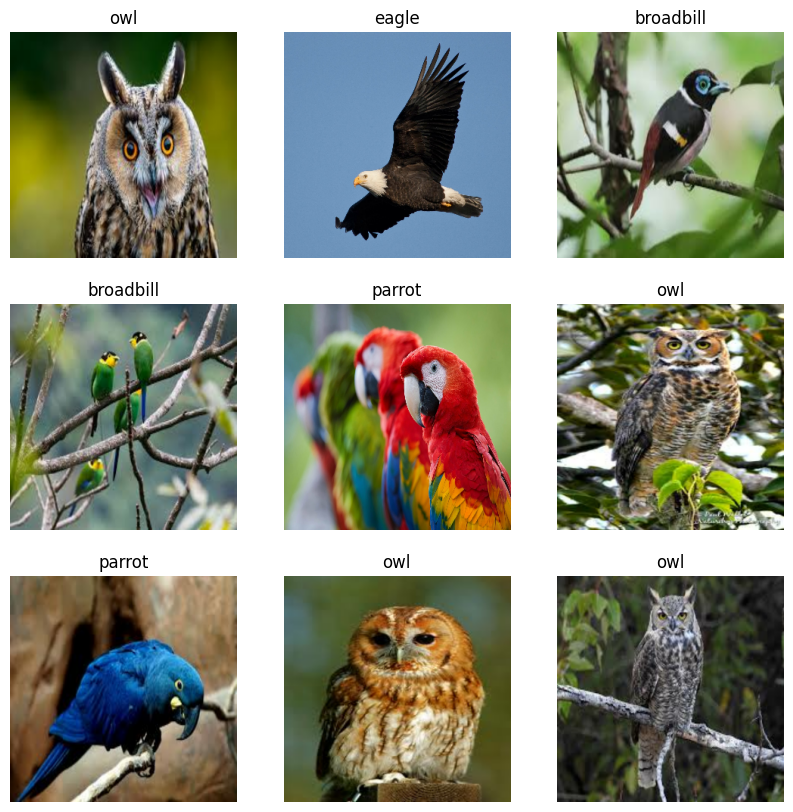

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [9]:
epochs=15
model.fit(train_ds,validation_data=val_ds,epochs=epochs)


#Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 1.4039 - accuracy: 0.2188 - val_loss: 10.2586 - val_accuracy: 0.2500
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 6.1890 - accuracy: 0.2500 - val_loss: 10.4910 - val_accuracy: 0.1250
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 7.9902 - accuracy: 0.2812 - val_loss: 4.2559 - val_accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 3.8396 - accuracy: 0.5000 - val_loss: 2.7609 - val_accuracy: 0.1250
Epoch 5/15
1/1 [==============================] - 1s 1s/step - loss: 2.8944 - accuracy: 0.4375 - val_loss: 1.9989 - val_accuracy: 0.0000e+00
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 1.9912 - accuracy: 0.4688 - val_loss: 1.4946 - val_accuracy: 0.1250
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 1.2508 - accuracy: 0.4375 - val_loss: 1.3721 - val_accuracy: 0.1250
Epoch 8/15
1/1 [===============

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [10]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

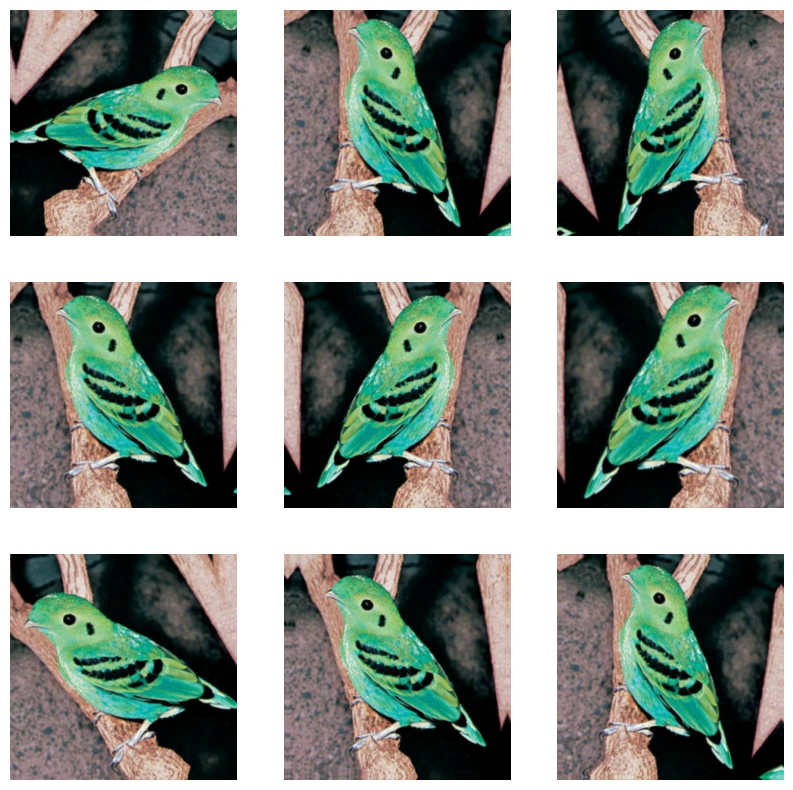

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [13]:
img = keras.preprocessing.image.load_img(
    "birds/eagle/5.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 153ms/step
This image most likely belongs to eagle with a 87.56 percent confidence.
